In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalIsingModel


from regain import utils; reload(utils);


# ISING

In [2]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
#import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=10,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [3]:
import pickle as pkl
with open("../../../../projects/time_exponential_family/data/data_ising_temporal_test_10nodes.pkl", "wb") as f:
    pkl.dump([samples, thetas], f)

In [4]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

In [ ]:
ising_mdl = Ising_GLM_GM(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)

In [18]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=10)

precisions = []
for train, test in sss.split(samples[0]):
    precs= []
    for i, e in enumerate(estimators):
        e.fit(samples[i][train, :])
        precs.append(e.precision_)
    precisions.append(np.array(precs))

In [30]:
precisions[0].shape

(10, 5, 5)

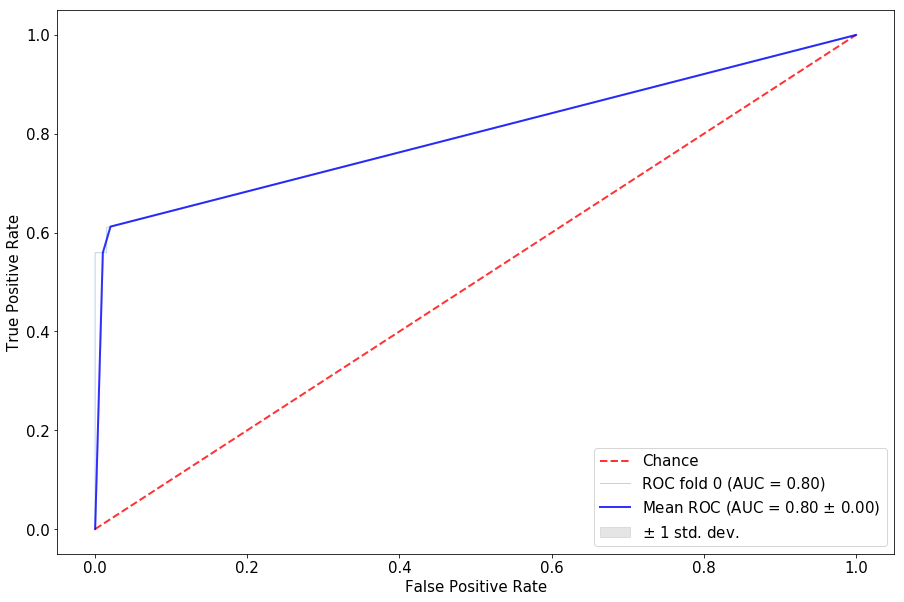

In [33]:
plot_roc_curves(np.array(thetas), [np.abs(precisions[2])])

In [460]:
ising_mdl.get_params()

{'alpha': 0.32,
 'compute_objective': True,
 'max_iter': 100,
 'mode': 'symmetric_fbs',
 'reconstruction': 'union',
 'return_history': True,
 'return_n_iter': False,
 'rho': 1,
 'rtol': 0.0001,
 'tol': 0.0001,
 'verbose': 0}

In [8]:
utils.structure_error(np.array(thetas), np.array(precisions), no_diagonal=True)

{'tp': 66,
 'tn': 80,
 'fp': 2,
 'fn': 52,
 'precision': 0.9705882352941176,
 'recall': 0.559322033898305,
 'f1': 0.7096774193548386,
 'accuracy': 0.584,
 'false_omission_rate': 0.3939393939393939,
 'fdr': 0.029411764705882353,
 'npv': 0.6060606060606061,
 'prevalence': 0.472,
 'miss_rate': 0.4406779661016949,
 'fall_out': 0.024390243902439025,
 'specificity': 0.975609756097561,
 'plr': 22.932203389830505,
 'nlr': 0.4516949152542373,
 'dor': 50.76923076923077,
 'balanced_accuracy': 0.7674658949979329,
 'average_precision': 0.9999999999999998}

In [405]:
import pickle as pkl

In [409]:
with open("../../../../projects/time_exponential_family/results_ising/results_single.pkl", "wb") as f:
    pkl.dump([precisions, params], f)


In [ ]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                      sampling_size=800, plot=True, 
                                      n_repetitions=20)
cv.fit(X, y)

In [61]:
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalIsingModel

from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=10)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params),  psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernels.RBF, ker_param='auto',  init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [62]:
mdl.fit(X, y)

Find new theta: 9.999995
Find new theta: 0.018387


TemporalIsingModel(alpha=0.3816326530612245, assume_centered=True,
          compute_objective=True, distribution='ising', init='zeros',
          ker_param='auto',
          kernel=<class 'sklearn.gaussian_process.kernels.RBF'>,
          max_iter=300, max_iter_ext=100, psi='l1', return_history=False,
          rho=1.0, rtol=1e-05, tol=0.0001, update_rho_options=None,
          verbose=0)

In [72]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=10)

precisions_time = []
for train, test in sss.split(X, y):
    mdl.fit(X[train, :], y[train])
    precisions_time.append(mdl.precision_)

Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018387
Find new theta: 9.999995
Find new theta: 0.018388
Find new theta: 9.999995
Find new theta: 0.018387


In [12]:
utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)

{'tp': 72,
 'tn': 82,
 'fp': 0,
 'fn': 46,
 'precision': 1.0,
 'recall': 0.6101694915254238,
 'f1': 0.7578947368421053,
 'accuracy': 0.616,
 'false_omission_rate': 0.359375,
 'fdr': 0.0,
 'npv': 0.640625,
 'prevalence': 0.472,
 'miss_rate': 0.3898305084745763,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 0.3898305084745763,
 'dor': 0.0,
 'balanced_accuracy': 0.8050847457627119,
 'average_precision': 0.9999999999999998}

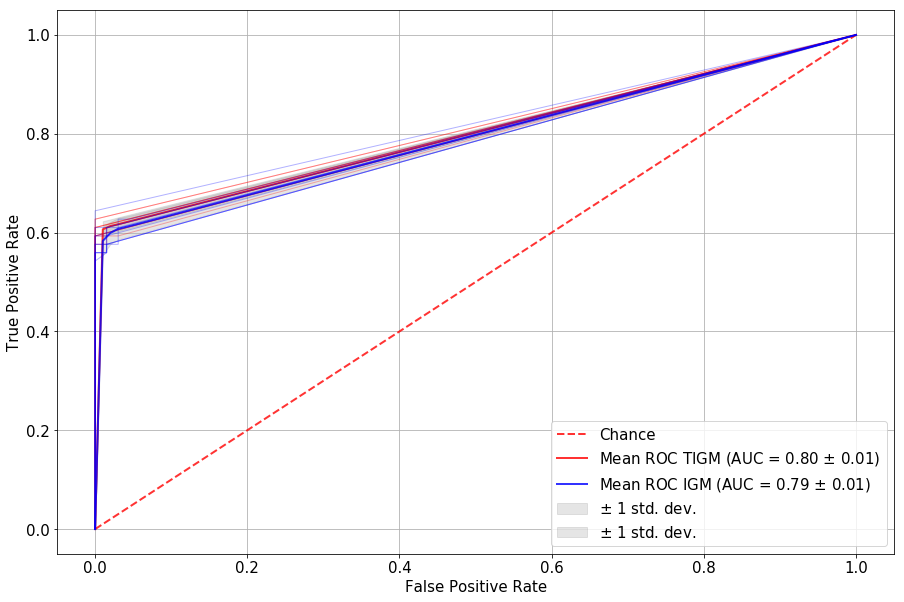

In [75]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_roc_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

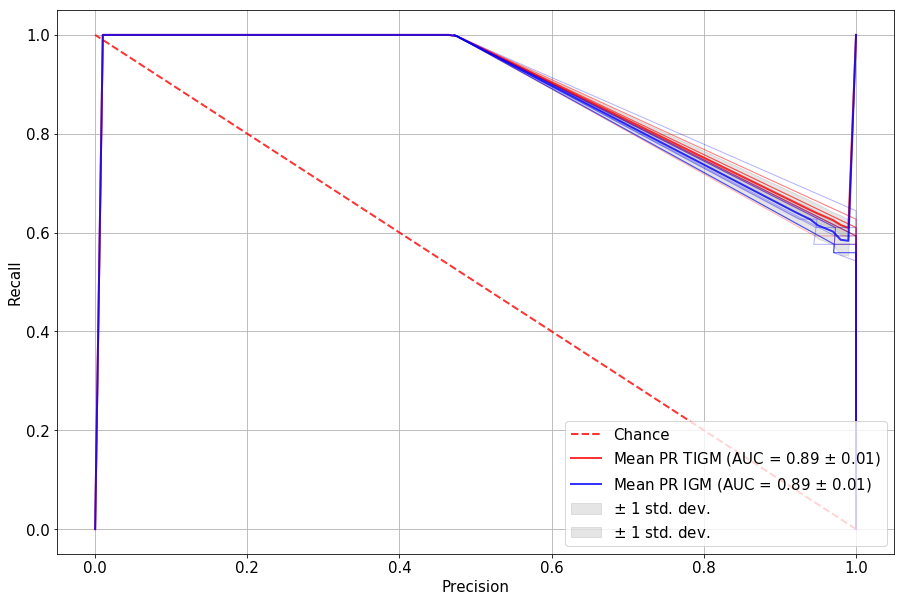

In [76]:
import regain.plotting.results; reload(regain.plotting.results)
from regain.plotting.results import plot_roc_curves, plot_precision_recall_comparison, plot_roc_comparison

plot_precision_recall_comparison(np.abs(np.array(thetas)), {'TIGM':[np.abs(p) for p in precisions_time],
                                                'IGM':[np.abs(p) for p in precisions]})

In [73]:
import regain.utils; reload(regain.utils)
from regain.utils import structure_error, mean_structure_error

In [74]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions])

{'tp': '71.0+/-2.569046515733026',
 'tn': '79.8+/-1.661324772583615',
 'fp': '2.2+/-1.661324772583615',
 'fn': '47.0+/-2.569046515733026',
 'precision': '0.9704822303506514+/-0.02088923349891197',
 'recall': '0.6016949152542372+/-0.02177158064180529',
 'f1': '0.7424983665635472+/-0.01717391882061649',
 'accuracy': '0.6032+/-0.01142628548566857',
 'false_omission_rate': '0.37045797392571583+/-0.01305327520581262',
 'fdr': '0.029517769649348602+/-0.02088923349891197',
 'npv': '0.6295420260742841+/-0.01305327520581258',
 'prevalence': '0.47199999999999986+/-1.1102230246251565e-16',
 'miss_rate': '0.39830508474576265+/-0.0217715806418053',
 'fall_out': '0.02682926829268293+/-0.020260058202239205',
 'specificity': '0.9731707317073169+/-0.0202600582022392',
 'plr': '16.631638418079095+/-9.908494098026464',
 'nlr': '0.4093920835334751+/-0.02242611996984835',
 'dor': '39.85754940711462+/-23.70592443365828',
 'balanced_accuracy': '0.7874328234807771+/-0.013788160615781177',
 'average_precision'

In [77]:
mean_structure_error(np.array(thetas), [np.abs(p) for p in precisions_time])

{'tp': '71.6+/-1.4966629547095764',
 'tn': '81.4+/-1.2806248474865698',
 'fp': '0.6+/-1.2806248474865698',
 'fn': '46.4+/-1.4966629547095767',
 'precision': '0.991891891891892+/-0.01730574118225094',
 'recall': '0.6067796610169491+/-0.012683584361945577',
 'f1': '0.7528560097051138+/-0.012216284478555873',
 'accuracy': '0.6119999999999999+/-0.008944271909999166',
 'false_omission_rate': '0.36302617521367525+/-0.009289907559444565',
 'fdr': '0.008108108108108109+/-0.017305741182250943',
 'npv': '0.6369738247863247+/-0.009289907559444567',
 'prevalence': '0.47199999999999986+/-1.1102230246251565e-16',
 'miss_rate': '0.39322033898305087+/-0.01268358436194557',
 'fall_out': '0.007317073170731709+/-0.01561737618886061',
 'specificity': '0.9926829268292682+/-0.01561737618886062',
 'plr': '3.7177966101694913+/-7.971938044118183',
 'nlr': '0.39628096479791397+/-0.015952536985923818',
 'dor': '9.10461956521739+/-19.74740287542427',
 'balanced_accuracy': '0.7997312939231087+/-0.01140752012201223